In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cbt
import datetime

from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
identity_cols = !head -1 data/train_identity.csv
identity_cols = identity_cols[0].split(',')

In [3]:
%%time
folder_path = 'data/'
train = pd.read_pickle(f'{folder_path}train.pkl')
test = pd.read_pickle(f'{folder_path}test.pkl')

CPU times: user 2.06 s, sys: 3.38 s, total: 5.44 s
Wall time: 5.38 s


In [4]:
N_TRAIN_EXAMPLES = 590540

In [5]:
N_TRAIN_EXAMPLES = len(train)

In [6]:
tr_am = pd.read_csv(f'{folder_path}train_transaction.csv', usecols=['TransactionAmt'], dtype=str)
te_am = pd.read_csv(f'{folder_path}test_transaction.csv', usecols=['TransactionAmt'], dtype=str)
train[['dollars', 'cents']] = tr_am.TransactionAmt.str.split('.', expand=True).astype(int)
test[['dollars', 'cents']] = te_am.TransactionAmt.str.split('.', expand=True).astype(int)

In [7]:
roman_df = pd.read_pickle('all_new_ids_roman_features.pkl')

In [8]:
roman_feature_names = set(roman_df.columns)

In [9]:
MODEL_FEATURES = set(test.columns) - set(['TransactionDT', 'TransactionID'])

In [10]:
basic_features = set(test.columns) - set(['TransactionDT', 'TransactionID'])

In [11]:
CATEGORICAL_FEATURES =  set(['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
            'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
            'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 
            'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'])

Говорят, что неплохо бы дропнуть те карты, которые не встречается или в трейне, или в тесте

In [12]:
for col in ['card1']: 

    print('No intersection in Train', len(train[~train[col].isin(test[col])]))
    print('Intersection in Train', len(train[train[col].isin(test[col])]))
    
    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)
    print('#'*20)

for col in ['card2','card3','card4','card5','card6',]: 
    print('No intersection in Train', col, len(train[~train[col].isin(test[col])]))
    print('Intersection in Train', col, len(train[train[col].isin(test[col])]))
    
    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)
    print('#'*20)

No intersection in Train 10396
Intersection in Train 580144
####################
No intersection in Train card2 5012
Intersection in Train card2 585528
####################
No intersection in Train card3 47
Intersection in Train card3 590493
####################
No intersection in Train card4 0
Intersection in Train card4 590540
####################
No intersection in Train card5 7279
Intersection in Train card5 583261
####################
No intersection in Train card6 30
Intersection in Train card6 590510
####################


In [13]:
roman_df.reset_index(inplace=True)

In [14]:
roman_df.head()

,TransactionDT_to_datetime,is_holiday,card1_mean_time_between_transactions,card1_median_time_between_transactions,time_from_prev_transaction_by_card1_ratio_to_mean,time_from_prev_transaction_by_card1_ratio_to_median,time_to_next_transaction_by_card1_ratio_to_mean,time_to_next_transaction_by_card1_ratio_to_median,card1_subcard_categorical_mean_time_between_transactions,card1_subcard_categorical_median_time_between_transactions,...,smoothed_encoded_addr1_on_R_emaildomain_nunique,smoothed_encoded_addr1_on_ProductCD_nunique,smoothed_encoded_R_emaildomain_on_P_emaildomain_nunique,smoothed_encoded_P_emaildomain_on_R_emaildomain_nunique,smoothed_encoded_card2_on_card1_nunique,smoothed_encoded_card4_on_card1_nunique,smoothed_encoded_card6_on_card1_nunique,smoothed_encoded_card2_card3_on_card1_nunique,smoothed_encoded_addr1_on_card1_nunique,smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_on_TransactionAmt_sum
0,2017-12-01 00:00:00,0,5.149471e+05,166474.0,NaN,NaN,1.598232,4.943745,NaN,NaN,...,33.0,4.0,NaN,NaN,NaN,21.0,7214.0,NaN,1750.0,68.50
1,2017-12-01 00:00:01,0,2.355974e+04,10762.5,NaN,NaN,0.635406,1.390941,24632.333333,11055.0,...,39.0,5.0,NaN,54.0,21.0,5750.0,7214.0,19.0,2205.0,29.00
2,2017-12-01 00:01:09,0,1.756653e+04,7360.5,NaN,NaN,0.014573,0.034780,431538.489362,352854.0,...,41.0,5.0,NaN,20.0,125.0,9705.0,9994.0,125.0,1886.0,106.95
3,2017-12-01 00:01:39,0,4.128710e+03,1905.0,NaN,NaN,0.266911,0.578478,151054.022727,19812.0,...,34.0,4.0,NaN,43.0,34.0,5750.0,9994.0,34.0,1018.0,286.95
4,2017-12-01 00:01:46,0,1.008091e+06,690866.0,NaN,NaN,1.335791,1.949145,NaN,NaN,...,25.0,4.0,NaN,54.0,117.0,5750.0,7214.0,116.0,642.0,50.00


In [15]:
all_df = pd.concat([train, test])
all_df.reset_index(inplace=True, drop=True)
all_df = pd.concat([all_df, roman_df], axis=1)

# Фичи по датам

In [16]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
all_df['DT'] = all_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))

In [17]:
del train, test, roman_df

In [18]:
import gc

In [19]:
gc.collect()

80

In [20]:
def datetime_features(all_df):
    all_df['DT'] = all_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    all_df['dayofweek'] = all_df['DT'].dt.dayofweek
    all_df['dayofmonth'] = all_df['DT'].dt.day
    all_df['hour'] = all_df['DT'].dt.hour
    all_df['weekofmonth'] = (all_df['DT'].dt.day - 1) // 7 + 1
    new_features = ['dayofweek', 'dayofmonth', 'hour', 'weekofmonth']
    return new_features, new_features

In [21]:
%%time
a, c = datetime_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

CPU times: user 1.44 s, sys: 45.6 ms, total: 1.49 s
Wall time: 1.49 s


In [22]:
all_df['DT_split'] = (all_df['DT'].dt.year - 2017) * 12 + all_df['DT'].dt.month
N_TRAIN = sum(all_df['DT_split'] < 17)

In [23]:
all_df['day'] = ((all_df['DT'].dt.year-2017)*365 + all_df['DT'].dt.dayofyear).astype(np.int16)
all_df['hour_day'] = all_df['DT'].dt.hour + 24 * (all_df['day'] - 335)

# D-features

In [24]:
d_cols = [col for col in all_df.columns if col.startswith('D') and not col[-1:].isalpha() and col != 'D9']

In [25]:
d_cols

['D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8']

In [26]:
d_cols_notnull = [d + '_notnull' for d in d_cols + ['D9']]
all_df[d_cols_notnull] = all_df[d_cols + ['D9']].notnull()

In [27]:
# Lets transform D8 and D9 column
# As we almost sure it has connection with hours
all_df['D8_not_same_day'] = np.where(all_df['D8']>=1,1,0)
all_df['D8_D9_decimal_dist'] = all_df['D8'].fillna(0)-all_df['D8'].fillna(0).astype(int)
all_df['D8_D9_decimal_dist'] = ((all_df['D8_D9_decimal_dist']-all_df['D9'])**2)**0.5
all_df['D8'] = all_df['D8'].fillna(-1).astype(int)

In [28]:
MODEL_FEATURES.update(['D8_not_same_day', 'D8_D9_decimal_dist', 'D8_D9_decimal_dist'])

In [29]:
def values_normalization(all_df, period, col, clip=True, minmax=True):
        new_col = col + '_' + period
        df = all_df[[col, period]].copy()
        df[col] = df[col].astype(float)
        if clip:
            df[col] = df[col].clip(0) 

        aggs = df.groupby([period])[col].agg(['min', 'max', 'std', 'mean'])
        
        agg_max = aggs['max'].to_dict()
        agg_min = aggs['min'].to_dict()
        agg_std = aggs['std'].to_dict()
        agg_mean = aggs['mean'].to_dict()

        all_df['temp_min'] = all_df[period].map(agg_max)
        all_df['temp_max'] = all_df[period].map(agg_min)
        all_df['temp_std'] = all_df[period].map(agg_std)
        all_df['temp_mean'] = all_df[period].map(agg_mean)
        

        all_df[new_col + '_min_max'] = ((all_df[col] - all_df['temp_min']) /\
                (all_df['temp_max'] - all_df['temp_min'])).astype(float)
        
        all_df[new_col + '_std_score'] = (all_df[col] - all_df['temp_mean']) / (all_df['temp_std'])

        del all_df['temp_min'], all_df['temp_max'], all_df['temp_std'], all_df['temp_mean']

In [30]:
%%time
for period in ['day']:
    for col in d_cols:
        values_normalization(all_df, period, col, minmax=True)

CPU times: user 38.8 s, sys: 1min 8s, total: 1min 47s
Wall time: 1min 47s


In [31]:
for col in ['D1','D2']:
    all_df[col + '_scaled'] = all_df[col] / all_df[:N_TRAIN_EXAMPLES][col].max()

In [32]:
MODEL_FEATURES.update(['D1_scaled', 'D2_scaled'])

# Device info

In [33]:
all_df['DeviceInfo'].fillna('', inplace=True)
all_df['id_30'].fillna('', inplace=True)
all_df['id_31'].fillna('', inplace=True)

In [34]:
def add_device_features(all_df):
    all_df['DeviceInfoMajor'] = all_df['DeviceInfo'].str.split(' ', expand=True)[0]
    all_df['DeviceInfoTop'] = all_df['DeviceInfo'].str.split('-', expand=True)[0]
    all_df['DeviceInfoIsRV'] = all_df['DeviceInfoMajor'].apply(lambda x: 'rv' in x)
    return ['DeviceInfoMajor', 'DeviceInfoTop', 'DeviceInfoIsRV'], ['DeviceInfoMajor', 'DeviceInfoTop']

In [35]:
%%time
a, c = add_device_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

CPU times: user 4.45 s, sys: 86.3 ms, total: 4.54 s
Wall time: 4.54 s


In [36]:
def split_version(version):
    n_sep_a = version.count('.')
    n_sep_b = version.count('_')
    if n_sep_a > 0:
        return version.split('.')[0]
    elif n_sep_b > 0:
        return version.split('_')[0]
    else:
        return version

def split_os(os):
    spl = os.split(' ')
    if len(spl) > 1:
        os_name = ' '.join(spl[:-1])
        major_version = split_version(spl[-1])
        return os_name, ' '.join([os_name, major_version])
    else:
        return os, ''
# TODO: add minor

In [37]:
def add_os_features(all_df):
    os, version = zip(*all_df['id_30'].apply(lambda x: split_os(x)).values)
    all_df['OSName'] = os
    all_df['OSMajorVersion'] = version
    return ['OSName', 'OSMajorVersion'], ['OSName', 'OSMajorVersion']

In [38]:
%%time
a, c = add_os_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

CPU times: user 1.62 s, sys: 48 ms, total: 1.67 s
Wall time: 1.67 s


In [39]:
# SHAME ON ME
def get_browser(browser):
    if 'safari' in browser:
        return 'safari'
    
    if 'chrome' in browser:
        return 'chrome'
    
    if browser.startswith('ie'):
        return 'internetexplorer'
    
    if 'edge' in browser:
        return 'edge'
    
    if 'firefox' in browser.lower():
        return 'firefox'
    
    if 'samsung' in browser.lower():
        return 'samsung'
    
    if 'google' in browser:
        return 'google'
    
    if 'opera' in browser:
        return 'opera'
    
    if 'android' in browser.lower():
        return 'android'
    
    return browser

def is_mobile(browser):
    br = browser.lower()
    if 'mobile' in br or 'for android' in br:
        return True
    else:
        return False


In [40]:
def get_browser_features(all_df):
    all_df['Browser'] = all_df['id_31'].apply(lambda x: get_browser(x))
    all_df['IsMobile'] = all_df['id_31'].apply(lambda x: is_mobile(x))
    #all_df['VersionNum'] = all_df['id_31'].fillna('0').\
    #    apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    #all_df['BrowserVersion'] = all_df['Browser'] + ' ' + all_df['VersionNum'].astype('str')
    
    return ['Browser', 'IsMobile'],  ['Browser', 'IsMobile']

In [41]:
%%time
a, c = get_browser_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

CPU times: user 839 ms, sys: 3.03 ms, total: 842 ms
Wall time: 842 ms


In [42]:
all_df.shape

(1097231, 899)

# Some with M

In [43]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

all_df['M_sum'] = all_df[i_cols].sum(axis=1).astype(np.int8)
all_df['M_na'] = all_df[i_cols].isna().sum(axis=1).astype(np.int8)

MODEL_FEATURES.update(['M_sum', 'M_na'])

# NaN count

In [44]:
all_df['notnull_count'] = all_df[basic_features].notnull().sum(axis=1)

In [45]:
MODEL_FEATURES.add('notnull_count')

# UID

In [46]:
cols_for_uid = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']

In [47]:
all_df[cols_for_uid] = all_df[cols_for_uid].astype(str)

In [113]:
def extract_registration_date(df):
    tr_dt = 'TransactionDT'

    df[f'{tr_dt}_to_datetime'] = df[tr_dt].apply(
        lambda x: START_DATE + datetime.timedelta(seconds=x)
    )

    df['card_registered_delta_tmp'] = pd.to_timedelta(df['D1'], unit='day')
    df['subcard_reg_date'] = (
            df['TransactionDT_to_datetime'] - df['card_registered_delta_tmp']
    )
    df['subcard_reg_timestamp'] = df['subcard_reg_date']\
        .dt\
        .date\
        .apply(
        lambda x: (
                x - datetime.date(1970, 1, 1)
        ).total_seconds()
    )
    df['subcard_categorical'] = df['subcard_reg_date']\
        .dt\
        .date\
        .astype(str)
    
    df['card_registered_delta_tmp'] = pd.to_timedelta(df['D4'], unit='day')
    df['subcard_reg_date'] = (
            df['TransactionDT_to_datetime'] - df['card_registered_delta_tmp']
    )
    df['subcard_reg_timestamp'] = df['subcard_reg_date']\
        .dt\
        .date\
        .apply(
        lambda x: (
                x - datetime.date(1970, 1, 1)
        ).total_seconds()
    )
    df['subcard_categorical_D4'] = df['subcard_reg_date']\
        .dt\
        .date\
        .astype(str)

    df.drop(
        labels=[
            'card_registered_delta_tmp',
            'subcard_reg_date'
        ],
        axis=1,
        inplace=True
    )

    return df

In [114]:
all_df = extract_registration_date(all_df)

In [50]:
all_df['subcard_categorical_full'] = all_df['card1'] + '_' + all_df['subcard_categorical'].astype('str')
all_df['subcard_categorical_D4_fill'] = all_df['card1'] + '_' + all_df['subcard_categorical_D4'].astype('str')

In [51]:
subcard_id_cols = ['addr1', 'DeviceInfo', 'P_emaildomain', 'ProductCD',
                   'id_20', 'id_19', 'card4', 'subcard_categorical_D4']

In [52]:
subcard_ids = []
for coll in subcard_id_cols:
    if not isinstance(coll, str):
        col = '_'.join(coll)
        all_df['subcard_' + col] = all_df['subcard_categorical_full'].astype(str) + '_' +\
            all_df[list(coll)].astype(str).apply(lambda x: '_'.join(x), axis=1)
    else:
        col = coll
        all_df['subcard_' + col] = all_df['subcard_categorical_full'].astype(str) + '_' +\
            all_df[coll].astype(str)
    
    subcard_ids.append('subcard_' + col)

In [88]:
MODEL_FEATURES.update(['subcard_categorical', 'subcard_categorical_full', 'subcard_categorical_D4_fill'])
CATEGORICAL_FEATURES.update(['subcard_categorical', 'subcard_categorical_full', 'subcard_categorical_D4_fill'])

In [54]:
MODEL_FEATURES.update(subcard_ids)
CATEGORICAL_FEATURES.update(subcard_ids)

In [55]:
all_df['uid1'] = all_df['card1'] + '_' + all_df['card2']

all_df['uid2'] = all_df['uid1'] + '_' + all_df['card3'] + '_' + all_df['card5']

all_df['uid3'] = all_df['uid2'] + '_' + all_df['addr1'] + '_' + all_df['addr2']

all_df['uid4'] = all_df['uid3'] + '_' + all_df['P_emaildomain']

all_df['uid5'] = all_df['uid3'] + '_' + all_df['R_emaildomain']


In [56]:
uids = [f'uid{i}' for i in range(1, 6)] + ['subcard_categorical_full'] + subcard_ids

In [57]:
subcard_ids

['subcard_addr1',
 'subcard_DeviceInfo',
 'subcard_P_emaildomain',
 'subcard_ProductCD',
 'subcard_id_20',
 'subcard_id_19',
 'subcard_card4',
 'subcard_subcard_categorical_D4']

 # TransactionAmt features

Говорят, если в сумме транзакции есть более двух чисел после запятой, то это транзакция в иностранной валюте

In [58]:
all_df['is_foreign'] = all_df['cents'].apply(lambda x: len(str(x)) > 2)

In [59]:
MODEL_FEATURES.add('is_foreign')

А раз уникальных TransactionAmt не очень много, то почему бы не добавить nunique для каждого из айдишников сверху

In [60]:
from sklearn.preprocessing import QuantileTransformer
from collections import Counter

In [61]:
%%time
unique_amt_cols = []
for uid in uids:
    uniques = all_df.groupby(uid)['TransactionAmt'].nunique()
    all_df[uid + '_unique_amt'] = all_df[uid].map(uniques)
    unique_amt_cols.append(uid + '_unique_amt')
    
QT = QuantileTransformer(n_quantiles=500)
all_df[unique_amt_cols] = QT.fit_transform(all_df[unique_amt_cols])

CPU times: user 29.5 s, sys: 17.1 s, total: 46.5 s
Wall time: 46.5 s


In [62]:
MODEL_FEATURES.update(unique_amt_cols)

# Следующая транзакция

In [ ]:
%%time
near_cols = []
same_cols = []
for col in ['card1', 'subcard_categorical_full'] + subcard_ids:
    print(col)
    for i in range(1, 5):
        print(i)
        a = 'is_same_next_transaction_' + str(i)
        b = 'is_same_prev_transaction_' + str(i)
        all_df[a] = all_df.groupby(col)['TransactionAmt'].diff(i) == 0
        all_df[b] = all_df.groupby(col)['TransactionAmt'].diff(-i) == 0
        same_cols.extend([a, b])
    all_df[f'same_transaction_near_{col}'] = all_df[same_cols].sum(axis=1)
    all_df.drop(same_cols, axis=1, inplace=True)
    near_cols.append(f'same_transaction_near_{col}')

card1
1
2
3
4
subcard_categorical_full
1
2
3
4
subcard_addr1
1
2
3
4
subcard_DeviceInfo
1
2
3
4
subcard_P_emaildomain
1
2
3
4
subcard_ProductCD
1
2
3
4
subcard_id_20
1
2
3
4
subcard_id_19
1
2
3


In [ ]:
MODEL_FEATURES.update(near_cols)

# Frequency Encoding

In [ ]:
def encode_frequency(col, quantile=True):
    return col.map(col.value_counts().to_dict())

In [ ]:
uids

In [ ]:
%%time
freq_cols = []
for col in list(CATEGORICAL_FEATURES) + uids + ['cents', 'dollars'] :
    all_df[col + '_freq'] = encode_frequency(all_df[col])
    freq_cols.append(col + '_freq')
    
QT = QuantileTransformer(n_quantiles=500)
all_df[freq_cols] = QT.fit_transform(all_df[freq_cols])

In [ ]:
MODEL_FEATURES.update(freq_cols)

# Categorical

In [ ]:
from multiprocessing import Pool

In [ ]:
def encode(col):
    le = LabelEncoder()
    le.fit(all_df[col].astype(str).values)
    return le.transform(all_df[col].astype(str).values)

In [ ]:
all_df['cents_categorical'] = all_df['cents'].copy()
all_df['dollars_categorical'] = all_df['dollars'].copy()

In [ ]:
CATEGORICAL_FEATURES.update(['cents_categorical', 'dollars_categorical'])

In [ ]:
MODEL_FEATURES.update(['cents_categorical', 'dollars_categorical'])

In [126]:
%%time
with Pool(16) as pool:
    encodes = pool.map(encode, CATEGORICAL_FEATURES)

for name, enc in zip(CATEGORICAL_FEATURES, encodes):
    all_df[name] = enc

CPU times: user 231 ms, sys: 5.36 s, total: 5.59 s
Wall time: 7.45 s


# Numerical encoding

In [ ]:
def calc_smooth_encoding(all_df, by, on, m):
    # Compute the global mean
    mean = all_df[on].mean()
    
    std = all_df[on].std()
    
    median = np.nanmedian(all_df[on])

    # Compute the number of values and the mean of each group
    agg = all_df.groupby(by)[on].agg(['count', 'mean', 'std', np.nanmedian])
    counts = agg['count']
    means = agg['mean']
    stds = agg['std']
    medians = agg['nanmedian']
    

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    
    smooth_std = (stds * counts + m * std ) / (counts + m)
    
    smooth_median = (medians * counts + m * median ) / (counts + m)

    # Replace each value by the according smoothed mean
    return all_df[by].map(smooth), all_df[by].map(smooth_std), all_df[by].map(smooth_median)

In [ ]:
%%time
amt_features = []
for col in uids:
    mean, std, median = calc_smooth_encoding(all_df, col, 'TransactionAmt', 30)
    all_df[col + '_TransactionAmt_mean'] = mean
    all_df[col + '_TransactionAmt_std'] = std
    #all_df[col + '_TransactionAmt_median'] = median
    amt_features.extend([col + '_TransactionAmt_mean', col + '_TransactionAmt_std'])#, col + '_TransactionAmt_median'])

In [ ]:
%%time
D15_features = []
for col in uids:
    mean, std, median = calc_smooth_encoding(all_df, col, 'D15_day_min_max', 30)
    all_df[col + '_D15_mean'] = mean
    all_df[col + '_D15_std'] = std
    #all_df[col + '_D15_median'] = median
    D15_features.extend([col + '_D15_mean', col + '_D15_std'])#, col + '_D15_median'])

In [ ]:
%%time
C13_features = []
for col in uids:
    mean, std, median = calc_smooth_encoding(all_df, col, 'C13', 30)
    all_df[col + '_C13_mean'] = mean
    all_df[col + '_C13_std'] = std
    #all_df[col + '_C13_median'] = median
    C13_features.extend([col + '_C13_mean', col + '_C13_std'])#, col + '_C13_median']

In [109]:
C13_features

['uid1_C13_mean',
 'uid1_C13_std',
 'uid2_C13_mean',
 'uid2_C13_std',
 'uid3_C13_mean',
 'uid3_C13_std',
 'uid4_C13_mean',
 'uid4_C13_std',
 'uid5_C13_mean',
 'uid5_C13_std',
 'subcard_categorical_full_C13_mean',
 'subcard_categorical_full_C13_std',
 'subcard_addr1_C13_mean',
 'subcard_addr1_C13_std',
 'subcard_DeviceInfo_C13_mean',
 'subcard_DeviceInfo_C13_std',
 'subcard_P_emaildomain_C13_mean',
 'subcard_P_emaildomain_C13_std',
 'subcard_ProductCD_C13_mean',
 'subcard_ProductCD_C13_std',
 'subcard_id_20_C13_mean',
 'subcard_id_20_C13_std',
 'subcard_id_19_C13_mean',
 'subcard_id_19_C13_std',
 'subcard_card4_C13_mean',
 'subcard_card4_C13_std',
 'subcard_subcard_categorical_D4_C13_mean',
 'subcard_subcard_categorical_D4_C13_std']

In [110]:
MODEL_FEATURES.update(D15_features + C13_features)

In [111]:
MODEL_FEATURES.update(amt_features)

In [115]:
values_normalization(all_df, 'day', 'subcard_reg_timestamp')

In [127]:
MODEL_FEATURES.add('subcard_reg_timestamp_day_min_max')

In [128]:
all_df.to_pickle('subcard_strikes_back_features.pkl')

# Splits

In [129]:
train_final = all_df[:N_TRAIN_EXAMPLES]
test_final = all_df[N_TRAIN_EXAMPLES:]

tr = train_final[:N_TRAIN]
val = train_final[N_TRAIN:]

In [130]:
def downsample(df, how_strong=2):
    positive = df[df.isFraud == 1]
    negative = df[df.isFraud == 0]
    negative = negative.sample(int(len(negative) / how_strong))
    res = pd.concat([positive, negative])
    return res.sample(len(res))

tr = downsample(tr, 10)
val = downsample(val, 10)

# Train

In [131]:
add_cols = [col + '_day_min_max' for col in d_cols] 
add_cols = add_cols + [col + '_day_std_score' for col in d_cols]

In [132]:
import sys
sys.path.insert(0, 'old_roman/IEEE_FRAUD/')

In [133]:
from settings import CATEGORICAL_FEATURES as roman_categorical

In [134]:
import pickle

In [135]:
roman_categorical = list(set(roman_categorical) - set(['is_holiday']))

In [136]:
final_features = set(list(MODEL_FEATURES) + list(roman_feature_names))

In [137]:
d_cols = [col for col in all_df.columns if col.startswith('D') 
          and not col[-1:].isalpha() and col != 'D9' and len(col) < 4]

In [138]:
good_cols = list(MODEL_FEATURES - set(['card1']) - set(d_cols) ) + add_cols + ['subcard_reg_timestamp_day_min_max']
good_categotical = list(set(CATEGORICAL_FEATURES) - set(['card1']))

In [139]:
all_good_features = set(good_cols
                        + list(roman_feature_names)) -\
    set(['card1', 'dayofmonth'])
all_good_categorical = set(good_categotical + roman_categorical) - set(['card1', 'is_holiday', 'dayofmonth'])

all_good_categorical = all_good_categorical.intersection(all_good_features)

In [140]:
with open('subcard_strikes_back_col_names.pkl', 'wb') as f:
    pickle.dump((MODEL_FEATURES, CATEGORICAL_FEATURES, roman_feature_names, roman_categorical,
                all_good_features, all_good_categorical), f)

# ПОСЛЕ ЭТОЙ СТРОЧКИ МОЖНО ПЕРЕЙТИ СРАЗУ К KFOLD

In [141]:
len(all_good_features)

1062

In [ ]:
dtrain = lgb.Dataset(tr[all_good_features], label=tr['isFraud'],
                     categorical_feature=all_good_categorical,free_raw_data=False)
dval = lgb.Dataset(val[all_good_features], label=val['isFraud'],
                   categorical_feature=all_good_categorical, free_raw_data=False)

In [ ]:
def fit_on_features(drop_feature):
    features = list(set(all_good_features) - set([drop_feature]))
    categorical = list(set(all_good_categorical) - set([drop_feature]))
    dtrain = lgb.Dataset(tr[features], label=tr['isFraud'],
                     categorical_feature=categorical,
                         free_raw_data=False)
    dval = lgb.Dataset(val[features], label=val['isFraud'],
                   categorical_feature=categorical,
                       free_raw_data=False)
    
    model = lgb.train(params, dtrain, num_boost_round=10000,
                  valid_sets=(dval, dtrain), valid_names=('val', 'train'),
                early_stopping_rounds=25, verbose_eval=0)
    return model.best_score

In [ ]:
params = {'num_leaves': 200,
          'min_child_samples': 40,
          #'min_sum_hessian_in_leaf': 5e-3,
          #'max_bin': 1023,
          #'min_data_in_leaf': 
          #'scale_pos_weight': 2,
          'objective': 'binary',
          'metric': 'auc',
          'max_depth': 13,
          'learning_rate': 0.01,
          "boosting_type": "goss",
          "top_rate": 0.6,
          "other_rate": 0.1,
          "bagging_freq": 0,
          'nthread': 16,
          
          'pos_bagging_fraction': 0.8,
          'neg_bagging_fraction': 0.01,
          "bagging_fraction": 0.6,
          "bagging_seed": 11,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          
          'feature_fraction': 0.7,
          'min_data_per_group': 25,
          'cat_smooth': 500,
          'max_cat_to_onehot': 8
          #'categorical_feature': cat_cols
         }

In [ ]:
%%time
model = lgb.train(params, dtrain, num_boost_round=10000,
                  valid_sets=(dval, dtrain), valid_names=('val', 'train'),
                early_stopping_rounds=25, verbose_eval=100)

In [ ]:
0.928021

0.94599 - дропаем -1e-4
0.946581 - дропаем -1e-3
0.949..- ничего не дропаем
0.949693 - дропнул 10

In [ ]:
DEFAULT_AUC = 0.9451639985019628

In [ ]:
import warnings

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    feature_metric_loss = {}
    for i, feature in enumerate(all_good_features):
        best_score = fit_on_features(feature)
        feature_metric_loss[feature] = DEFAULT_AUC - best_score['val']['auc']
        print(feature, f'with №{i} loss change:', feature_metric_loss[feature])

In [ ]:
import json

In [ ]:
with open('feature_auc_loss.json', 'w') as f:
    json.dump(feature_metric_loss, f)

In [ ]:
feature_imp = pd.DataFrame.from_dict(feature_metric_loss, orient='index')
feature_imp.reset_index(inplace=True)
feature_imp.columns = ['Feature', 'Value']


In [ ]:
feature_imp[feature_imp['Value'] < -0.001]

In [ ]:
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-100:])
plt.tight_layout()
plt.show()

In [ ]:
%%time
model = lgb.train(params, dtrain, num_boost_round=10000,
                  valid_sets=(dval, dtrain), valid_names=('val', 'train'),
                early_stopping_rounds=25, verbose_eval=100)

In [ ]:
model.best_score

In [ ]:
0.945351

In [ ]:
0.947028 0.946727 0.946764

In [ ]:
%%time
model = lgb.train(params, dtrain, num_boost_round=10000,
                  valid_sets=(dval, dtrain), valid_names=('val', 'train'),
                early_stopping_rounds=25, verbose_eval=25)

# Split importance

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('split'), good_cols)), columns=['Value','Feature'])
bad_cols = feature_imp[feature_imp['Value'] < 1]['Feature']
len(bad_cols)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('split'), all_good_features)), columns=['Value','Feature'])
bad_cols = feature_imp[feature_imp['Value'] < 1]['Feature']
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:100])
plt.tight_layout()
plt.show()

# SHAP importance

In [ ]:
shap_test = test_final.sample(7000)

In [ ]:
%%time
res = model.predict(shap_test[all_good_features], pred_contrib=True)
mean_shap = np.abs(res).mean(axis=0)
shap_imp = pd.DataFrame(sorted(zip(mean_shap, all_good_features)), columns=['Value','Feature'])
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=shap_imp.sort_values(by="Value", ascending=False)[:60])
plt.tight_layout()
plt.show()

# Fit KFold (Scary)

In [102]:
from sklearn.model_selection import GroupKFold

In [103]:
gkf = GroupKFold(6)

In [104]:
gkf

GroupKFold(n_splits=6)

In [107]:
params = {'num_leaves': 200,
          'min_child_samples': 40,
          #'min_sum_hessian_in_leaf': 5e-3,
          #'max_bin': 1023,
          #'min_data_in_leaf': 
          #'scale_pos_weight': 2,
          'objective': 'binary',
          'metric': 'auc',
          'max_depth': 13,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "top_rate": 0.6,
          "other_rate": 0.1,
          "bagging_freq": 0,
          'nthread': 16,
          
          'pos_bagging_fraction': 0.8,
          'neg_bagging_fraction': 0.01,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          
          'feature_fraction': 0.9,
          'min_data_per_group': 25,
          'cat_smooth': 500,
          'max_cat_to_onehot': 8
          #'categorical_feature': cat_cols
         }

In [142]:
import gc

del dtrain, dval

In [143]:
gc.collect()

9386

In [106]:
len(all_good_features)

1062

In [144]:
scores = []
all_preds = []
oofs = []
for train_ids, val_ids in gkf.split(train_final, train_final['isFraud'], train_final['DT_split']):
    df_tr = train_final.loc[train_ids]
    df_val = train_final.loc[val_ids]
    dtrain = lgb.Dataset(df_tr[all_good_features], label=df_tr['isFraud'],
                         categorical_feature=all_good_categorical, free_raw_data=False)
    dval = lgb.Dataset(df_val[all_good_features], label=df_val['isFraud'],
                       categorical_feature=all_good_categorical, free_raw_data=False)
    
    
    model = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=(dval),
                early_stopping_rounds=100, verbose_eval=100)
    preds = model.predict(test_final[all_good_features], num_iteration=model.best_iteration)
    
    all_preds.append(preds)
    
    oof_preds = model.predict(df_val[all_good_features], num_iteration=model.best_iteration)
    oofs.append(oof_preds)
    
    scores.append(model.best_score)

/home/a_tishurov/.conda/envs/experiments/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/a_tishurov/.conda/envs/experiments/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.889775
[200]	valid_0's auc: 0.902793
[300]	valid_0's auc: 0.910382
[400]	valid_0's auc: 0.91621
[500]	valid_0's auc: 0.91986
[600]	valid_0's auc: 0.922429
[700]	valid_0's auc: 0.924564
[800]	valid_0's auc: 0.925924
[900]	valid_0's auc: 0.926738
[1000]	valid_0's auc: 0.92795
[1100]	valid_0's auc: 0.928953
[1200]	valid_0's auc: 0.929714
[1300]	valid_0's auc: 0.93045
[1400]	valid_0's auc: 0.931054
[1500]	valid_0's auc: 0.931524
[1600]	valid_0's auc: 0.93191
[1700]	valid_0's auc: 0.932333
[1800]	valid_0's auc: 0.932576
[1900]	valid_0's auc: 0.932775
[2000]	valid_0's auc: 0.932948
[2100]	valid_0's auc: 0.933256
[2200]	valid_0's auc: 0.933419
[2300]	valid_0's auc: 0.933517
[2400]	valid_0's auc: 0.93372
[2500]	valid_0's auc: 0.933791
[2600]	valid_0's auc: 0.933857
[2700]	valid_0's auc: 0.934031
[2800]	valid_0's auc: 0.934124
[2900]	valid_0's auc: 0.934211
[3000]	valid_0's auc: 0.9343
[3100]	valid_0's auc: 0.

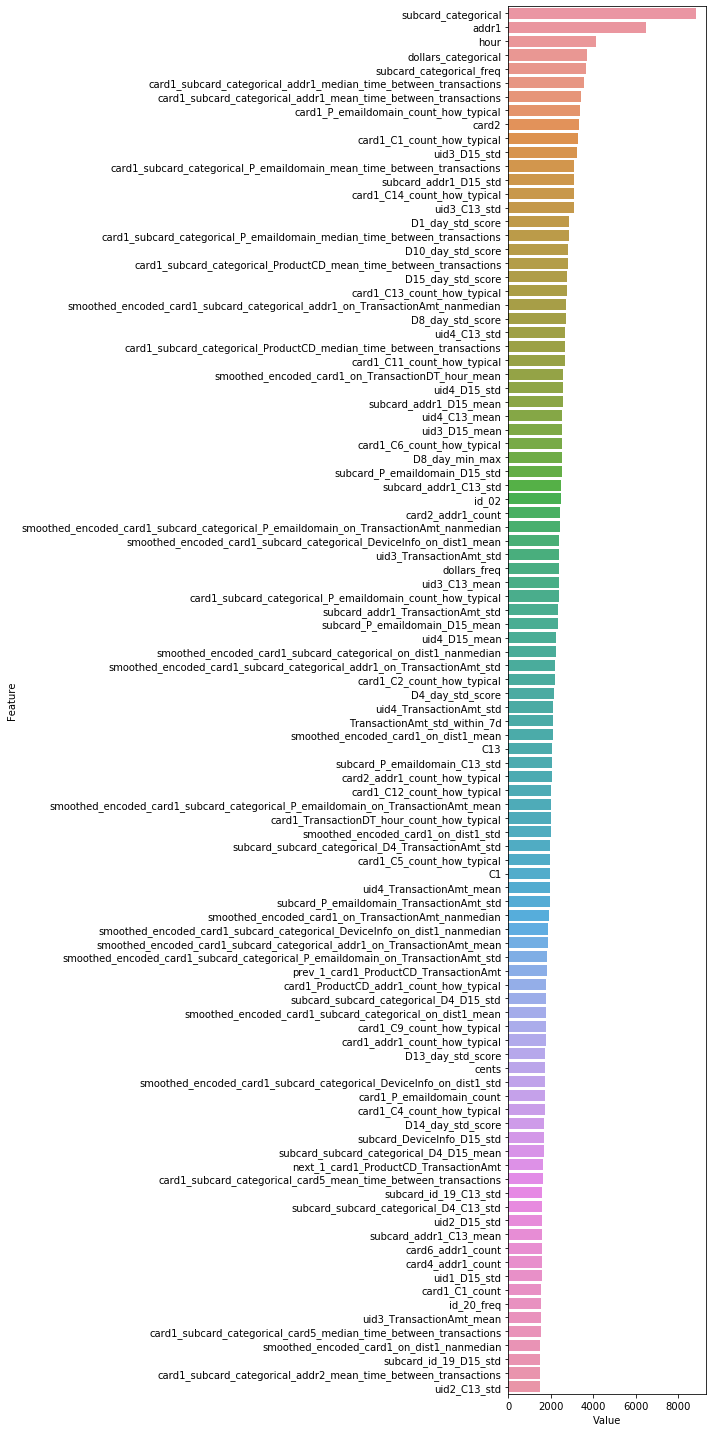

In [154]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('split'), all_good_features)), columns=['Value','Feature'])
bad_cols = feature_imp[feature_imp['Value'] < 1]['Feature']
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:100])
plt.tight_layout()
plt.show()

In [145]:
scores

[defaultdict(dict, {'valid_0': {'auc': 0.9343958189636883}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9608566943297293}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9637887533692641}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9534188190060433}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9588616240548543}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9686157011021619}})]

In [146]:
[score['valid_0']['auc'] for score in scores]

[0.9343958189636883,
 0.9608566943297293,
 0.9637887533692641,
 0.9534188190060433,
 0.9588616240548543,
 0.9686157011021619]

In [147]:
best_score = np.mean([score['valid_0']['auc'] for score in scores])

In [148]:
best_score

0.9566562351376237

In [149]:
from scipy.stats import gmean

In [150]:
from scipy.stats import gmean
gmean_preds = gmean(all_preds, axis=0)
np.corrcoef(gmean_preds, np.mean(all_preds, axis=0))

array([[1.        , 0.99908865],
       [0.99908865, 1.        ]])

In [151]:
filename = f'submissions/lgb_with_second_subcard{best_score:0.7}.csv.gz'

In [152]:
sub = pd.read_csv('data/sample_submission.csv')
sub['isFraud'] = gmean_preds
sub.to_csv(filename, index=False)

In [153]:
!KAGGLE_USERNAME=tishur KAGGLE_KEY=28da1297bec180204c1c524afa6f3d2e kaggle competitions submit ieee-fraud-detection -f {filename} -m "x"

100%|██████████████████████████████████████| 5.74M/5.74M [00:03<00:00, 1.57MB/s]
Successfully submitted to IEEE-CIS Fraud Detection